In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import google.cloud
import google.auth
import time
import xgboost as xgb

from PIL import Image
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model
from google.oauth2 import service_account
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [ ]:
credentials = service_account.Credentials.from_service_account_file(r"C:\Users\mkhoa\Documents\Credentials\csftmle-c5e5998b280a.json")

In [ ]:
# Training data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((y_train, y_test))

In [ ]:
print('Training data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)
print('Full data:', X_full.shape, y_full.shape)

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)
Full data: (70000, 28, 28) (70000,)


[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) can be used as drop-in replacement for the original MNIST dataset (10 categories of handwritten digits). It shares the same image size (28x28) and structure of training (60,000) and testing (10,000) splits. The class labels are:

| Label|	Description|
|-|-|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|

**Example**

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png" width="50%"/>

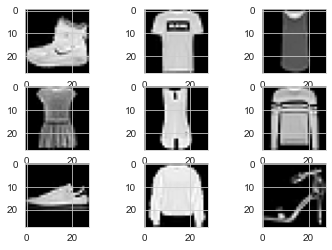

In [ ]:
# plot first 9 images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(np.array(X_train[i]), cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
class Reshape(BaseEstimator, TransformerMixin):    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        nsamples, nx, ny = X.shape
        X = X.reshape((nsamples, nx*ny))
        return X
    
class Scaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        X = X/255
        return X

# Logistic Regression
Base Model

In [ ]:
pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', LogisticRegression(max_iter=500, n_jobs=-1, multi_class='ovr')),
        ])
LogReg = pipeline.fit(X_train, y_train)

In [ ]:
joblib.dump(LogReg, 'LogReg.sav')

['LogReg.sav']

In [ ]:
LogReg = joblib.load('LogReg.sav')

In [ ]:
y_predict = LogReg.predict(X_test)
print(classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.798     0.808     0.803      1000
           1      0.976     0.960     0.968      1000
           2      0.725     0.735     0.730      1000
           3      0.833     0.863     0.848      1000
           4      0.730     0.758     0.744      1000
           5      0.947     0.924     0.935      1000
           6      0.623     0.564     0.592      1000
           7      0.905     0.938     0.921      1000
           8      0.937     0.941     0.939      1000
           9      0.949     0.943     0.946      1000

    accuracy                          0.843     10000
   macro avg      0.842     0.843     0.843     10000
weighted avg      0.842     0.843     0.843     10000



# Random Forest Classifier

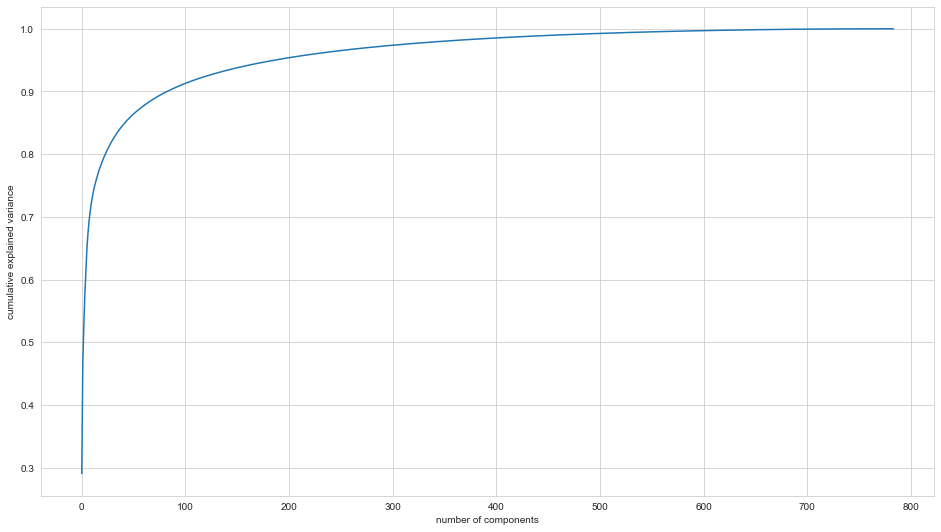

In [ ]:
nsamples, nx, ny = X_train.shape
X_data = X_train.reshape((nsamples, nx*ny))

sns.set_style('whitegrid')
pca = PCA().fit(X_data)
plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', RandomForestClassifier(n_jobs=-1)),
        ])

param_grid = [
    # {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'clf__n_estimators': [10, 50, 100], 'clf__max_features' : ['auto', 100, 200, 300, 784]}
  ]

gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 48.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reshape', Reshape()),
                                       ('scaler', Scaler()),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'clf__max_features': ['auto', 100, 200, 300, 784],
                          'clf__n_estimators': [10, 50, 100]}],
             return_train_score=True, verbose=3)

In [ ]:
joblib.dump(gscv.best_params_, 'RandomForrest_best.sav')
joblib.dump(gscv, 'RandomForrest.sav')

['RandomForrest.sav']

In [ ]:
rf = joblib.load('RandomForrest.sav')
rf.best_params_

{'clf__max_features': 100, 'clf__n_estimators': 100}

In [ ]:
y_predict = rf.predict(X_test)
print(classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.821     0.861     0.840      1000
           1      0.995     0.960     0.977      1000
           2      0.763     0.811     0.786      1000
           3      0.877     0.904     0.890      1000
           4      0.769     0.816     0.792      1000
           5      0.980     0.959     0.969      1000
           6      0.730     0.600     0.659      1000
           7      0.932     0.957     0.944      1000
           8      0.962     0.972     0.967      1000
           9      0.958     0.951     0.954      1000

    accuracy                          0.879     10000
   macro avg      0.879     0.879     0.878     10000
weighted avg      0.879     0.879     0.878     10000



# K-nearest neighbors Classifier

In [ ]:
pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', KNeighborsClassifier(n_jobs=-1)),
        ])

param_grid = [
    {'clf__n_neighbors': [5], 'clf__p': [1], 'clf__weights': ['distance']}
  ]

gscv = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__n_neighbors=5, clf__p=1, clf__weights=distance .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__n_neighbors=5, clf__p=1, clf__weights=distance, score=(train=1.000, test=0.869), total= 2.4min
[CV] clf__n_neighbors=5, clf__p=1, clf__weights=distance .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.9min remaining:    0.0s


[CV]  clf__n_neighbors=5, clf__p=1, clf__weights=distance, score=(train=1.000, test=0.859), total= 2.4min
[CV] clf__n_neighbors=5, clf__p=1, clf__weights=distance .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.9min remaining:    0.0s


[CV]  clf__n_neighbors=5, clf__p=1, clf__weights=distance, score=(train=1.000, test=0.861), total= 2.4min
[CV] clf__n_neighbors=5, clf__p=1, clf__weights=distance .............
[CV]  clf__n_neighbors=5, clf__p=1, clf__weights=distance, score=(train=1.000, test=0.865), total= 2.4min
[CV] clf__n_neighbors=5, clf__p=1, clf__weights=distance .............
[CV]  clf__n_neighbors=5, clf__p=1, clf__weights=distance, score=(train=1.000, test=0.859), total= 2.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 54.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reshape', Reshape()),
                                       ('scaler', Scaler()),
                                       ('clf',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid=[{'clf__n_neighbors': [5], 'clf__p': [1],
                          'clf__weights': ['distance']}],
             return_train_score=True, verbose=3)

In [ ]:
joblib.dump(gscv.best_params_, 'knn_best.sav')
joblib.dump(gscv, 'knn.sav')

['knn.sav']

In [ ]:
knn = joblib.load('knn.sav')
knn.best_params_

{'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}

In [ ]:
y_predict = knn.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.8615


# Support Vector Machine

In [ ]:
pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', SVC()),
        ])

param_grid = [
    # {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'clf__C': [1, 5, 10], 'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
  ]

gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 56.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 341.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reshape', Reshape()),
                                       ('scaler', Scaler()), ('clf', SVC())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1, 5, 10],
                          'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                          'precomputed']}],
             return_train_score=True, verbose=3)

In [ ]:
joblib.dump(gscv.best_params_, 'SVC_best.sav')
joblib.dump(gscv, 'SVC.sav')

['SVC.sav']

In [ ]:
svc = joblib.load('SVC.sav')
svc.best_params_

{'clf__C': 10, 'clf__kernel': 'rbf'}

In [ ]:
y_predict = svc.predict(X_test)
print(classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.839     0.853     0.846      1000
           1      0.993     0.973     0.983      1000
           2      0.811     0.836     0.823      1000
           3      0.905     0.910     0.907      1000
           4      0.833     0.835     0.834      1000
           5      0.973     0.974     0.974      1000
           6      0.749     0.718     0.733      1000
           7      0.951     0.962     0.956      1000
           8      0.978     0.980     0.979      1000
           9      0.971     0.961     0.966      1000

    accuracy                          0.900     10000
   macro avg      0.900     0.900     0.900     10000
weighted avg      0.900     0.900     0.900     10000



# Boosted Tree Classifier

In [ ]:
start = time.time()
pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', XGBClassifier(n_estimators=500, n_jobs=-1, learning_rate=0.5, seed=0, verbosity=2)),
        ])

pipeline.fit(X_train, y_train)
stop = time.time()
y_pred = pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f"Training time: {stop - start}s")

[21:49:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:49:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[21:49:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:49:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:49:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:49:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 96 extra nodes

[21:49:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:49:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:49:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[21:49:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:49:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:49:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 60 extra nodes, 0

[21:49:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:49:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:49:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:49:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:49:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:49:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 102 extra nodes,

[21:49:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:49:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:49:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:49:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:49:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:50:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 94 extra nodes, 0

[21:50:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:50:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:50:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:50:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:50:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:50:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0

[21:50:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[21:50:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:50:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:50:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:50:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:50:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes,

[21:50:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:50:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:50:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:50:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:50:48] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:50:48] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 84 extra nodes, 

[21:51:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:51:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:51:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:51:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[21:51:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:51:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes,

[21:51:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:51:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:51:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[21:51:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 76 extra nodes, 

[21:51:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[21:51:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0

[21:51:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:51:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:51:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:51:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:51:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:51:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nodes, 0

[21:52:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:52:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:52:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:52:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:52:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:52:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 

[21:52:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[21:52:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:52:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[21:52:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:52:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 

[21:52:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:52:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:52:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:52:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 p

[21:52:40] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[21:52:40] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[21:52:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:52:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:52:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 p

[21:52:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:52:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:52:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[21:52:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:52:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:52:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 p

[21:53:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:53:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:53:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:53:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[21:53:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:53:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 

[21:53:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[21:53:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:53:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[21:53:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:53:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:53:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 p

[21:53:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[21:53:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:53:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:53:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:53:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[21:53:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 p

[21:53:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[21:53:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[21:53:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[21:53:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:53:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 p

[21:53:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[21:53:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:53:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[21:53:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[21:53:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

[21:53:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[21:53:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:53:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 

[21:53:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:53:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:54:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:54:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:54:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:54:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:54:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[21:54:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[21:54:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:54:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:54:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:54:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 p

[21:54:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:54:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[21:54:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[21:54:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[21:54:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:54:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 p

[21:54:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:54:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:54:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:54:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:54:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:54:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 p

[21:54:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:54:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:54:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:54:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:54:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:54:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:54:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:54:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:54:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:54:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:54:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:54:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:54:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:54:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:54:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:54:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:54:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:54:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:55:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:55:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[21:55:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:55:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:55:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:55:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pr

[21:55:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:55:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:55:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:55:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:55:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:55:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pru

[21:55:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[21:55:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:55:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:55:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:55:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:55:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pru

[21:55:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:55:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[21:55:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[21:55:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:55:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:55:31] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 prun

[21:55:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[21:55:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:55:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[21:55:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:55:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:55:40] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pru

[21:55:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:55:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:55:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:55:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:55:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:55:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:56:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:56:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:56:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:56:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:56:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:56:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:56:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:56:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:56:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:56:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:56:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:56:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:56:18] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:56:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:56:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:56:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:56:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:56:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:56:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:56:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:56:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:56:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:56:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:35] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:56:35] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:56:35] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:56:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[21:56:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:56:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:56:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:56:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:56:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:56:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:56:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:56:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:56:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:56:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:56:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:56:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:56:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:56:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:56:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:57:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:57:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:57:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:57:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:57:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:57:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:57:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:57:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:57:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:57:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:57:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:57:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:57:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:57:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:57:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:57:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:57:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:57:21] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:57:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:57:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:57:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:57:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:57:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:57:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:57:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:57:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:57:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:57:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:57:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:57:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:57:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:57:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:57:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:57:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:57:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:57:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:57:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:57:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:57:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:57:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[21:57:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:57:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:57:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:57:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:57:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:57:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:57:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:58:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:58:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:58:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:58:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:58:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:58:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:58:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:58:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:58:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:58:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:58:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:58:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:58:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:58:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:58:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:58:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:58:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:58:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:58:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[21:58:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:58:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[21:58:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:58:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:58:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:58:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:58:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:58:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[21:58:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[21:58:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:58:38] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:58:38] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:58:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:58:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:58:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:58:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:58:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:58:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:58:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:58:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[21:58:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:58:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:58:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:58:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:58:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:59:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:59:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:59:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:59:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:59:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:59:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:59:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:59:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:59:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[21:59:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:59:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:59:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[21:59:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:59:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[21:59:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:59:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:59:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:59:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[21:59:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:59:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:59:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:59:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[21:59:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:59:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:59:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:59:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[21:59:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:59:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[21:59:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:59:45] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[21:59:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[21:59:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:59:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:59:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:59:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[21:59:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:59:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[21:59:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:59:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:59:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:59:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:00:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:00:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:00:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:00:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:00:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[22:00:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:00:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:00:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:00:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:00:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:00:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:20] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pru

[22:00:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:00:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[22:00:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:00:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:00:27] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:00:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:00:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[22:00:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:00:35] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[22:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:00:41] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:00:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:48] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:00:48] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:00:48] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[22:00:48] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:00:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:00:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:00:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:00:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:00:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:00:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:00:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:00:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pr

[22:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:01:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:01:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:01:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:01:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:01:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:01:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pr

[22:01:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:01:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[22:01:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:01:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pru

[22:01:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[22:01:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:01:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:01:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:01:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:01:23] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:01:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[22:01:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:01:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:01:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:01:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:01:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[22:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:36] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:01:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:01:37] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pru

[22:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pru

[22:01:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[22:01:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:01:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:01:51] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 prun

[22:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pru

[22:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[22:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[22:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pru

[22:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[22:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 prun

[22:02:18] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:02:18] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:02:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[22:02:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:02:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:02:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pr

[22:02:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:02:25] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:02:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:02:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:02:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:02:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pru

[22:02:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[22:02:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:02:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:02:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:02:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:02:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pru

[22:02:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[22:02:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[22:02:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:02:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:02:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:02:39] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pru

[22:02:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[22:02:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[22:02:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:02:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:02:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:02:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 prun

In [ ]:
start = time.time()
pipeline = Pipeline([
        ('reshape', Reshape()),
        ('clf', XGBClassifier(tree_method = 'gpu_hist', n_estimators=500, n_jobs=-1, learning_rate=0.5, seed=0, verbosity=2)),
        ])

pipeline.fit(X_train, y_train)
stop = time.time()
y_pred = pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f"Training time: {stop - start}s")

0.9041
Training time: 308.6956043243408s


In [ ]:
start = time.time()
param_grid = [
    # {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'clf__n_estimators': [100, 200, 500], 'clf__learning_rate' : [0.1, 0.3, 0.5]}
  ]

pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, seed=0, verbosity=3)),
        ])

gscv = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, verbose=2)
gscv.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] clf__learning_rate=0.1, clf__n_estimators=100 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:55:32] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[23:55:32] ======== Monitor: SketchContainer ========
[23:55:32] MakeCuts: 0.002668s, 1 calls @ 2668us

[23:55:32] Prune: 0.001744s, 1 calls @ 1744us

[23:55:32] Push: 6.2e-05s, 1 calls @ 62us

[23:55:32] Unique: 0.001602s, 2 calls @ 1602us

[23:55:32] ======== Monitor: xgboost::common::DenseCuts::DenseCuts ========
[23:55:32] ======== Monitor: xgboost::common::HistogramCuts::HistogramCuts ========
[23:57:56] ======== Monitor: Learner ========
[23:57:56] Configure: 0s, 1 calls @ 0us

[23:57:56] GetGradient: 1.25105s, 100 calls @ 1251054us

[23:57:56] PredictRaw: 0.528493s, 100 calls @ 528493us

[23:57:56] UpdateOneIter: 143.057s, 100 calls @ 143056716us

[23:57:56] ======== Monitor: GBTree ========
[23:57:56] BoostNewTrees: 142.275s, 100 calls @ 142275213us

[23:57:56] CommitModel: 8e-05s, 100 calls @ 80us

[23:57:56] ======== Device 0 Memory Allocation

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[23:57:58] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[23:57:59] ======== Monitor: SketchContainer ========
[23:57:59] MakeCuts: 0.036044s, 1 calls @ 36044us

[23:57:59] Prune: 0.022799s, 1 calls @ 22799us

[23:57:59] Push: 0.011855s, 1 calls @ 11855us

[23:57:59] Unique: 0.025014s, 2 calls @ 25014us

[23:57:59] ======== Monitor: xgboost::common::DenseCuts::DenseCuts ========
[23:57:59] ======== Monitor: xgboost::common::HistogramCuts::HistogramCuts ========
[00:00:37] ======== Monitor: Learner ========
[00:00:37] Configure: 0.000841s, 1 calls @ 841us

[00:00:37] GetGradient: 1.40234s, 100 calls @ 1402336us

[00:00:37] PredictRaw: 0.726306s, 100 calls @ 726306us

[00:00:37] UpdateOneIter: 158.738s, 100 calls @ 158737644us

[00:00:37] ======== Monitor: GBTree ========
[00:00:37] BoostNewTrees: 156.606s, 100 calls @ 156605697us

[00:00:37] CommitModel: 8.1e-05s, 100 calls @ 81us

[00:00:37] ======== Device 0

[00:06:12] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:06:12] ======== Device 0 Memory Allocations:  ========
[00:06:12] Peak memory usage: 580MiB
[00:06:12] Number of allocations: 753491
[00:06:12] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.1, clf__n_estimators=100, total= 2.8min
[00:06:14] ======== Monitor: Learner ========
[00:06:14] Configure: 0.00184s, 1 calls @ 1840us

[00:06:14] ======== Monitor: GBTree ========
[00:06:14] ======== Device 0 Memory Allocations:  ========
[00:06:14] Peak memory usage: 580MiB
[00:06:14] Number of allocations: 753495
[00:06:14] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.1, clf__n_estimators=100 ...................
[00:06:14] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:06:15] ======== Monitor: SketchContainer ========
[00:06:15] MakeCuts: 0.04

[00:12:19] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:12:19] ======== Device 0 Memory Allocations:  ========
[00:12:19] Peak memory usage: 580MiB
[00:12:19] Number of allocations: 1643119
[00:12:19] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total= 2.2min
[00:12:21] ======== Monitor: Learner ========
[00:12:21] Configure: 0.001375s, 1 calls @ 1375us

[00:12:21] ======== Monitor: GBTree ========
[00:12:21] ======== Device 0 Memory Allocations:  ========
[00:12:21] Peak memory usage: 580MiB
[00:12:21] Number of allocations: 1643123
[00:12:21] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................
[00:12:21] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:12:21] ======== Monitor: SketchContainer ========
[00:12:21] MakeCuts: 0

[00:19:01] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:19:01] ======== Device 0 Memory Allocations:  ========
[00:19:01] Peak memory usage: 580MiB
[00:19:01] Number of allocations: 2698436
[00:19:01] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total= 2.2min
[00:19:03] ======== Monitor: Learner ========
[00:19:03] Configure: 0.001265s, 1 calls @ 1265us

[00:19:03] ======== Monitor: GBTree ========
[00:19:03] ======== Device 0 Memory Allocations:  ========
[00:19:03] Peak memory usage: 580MiB
[00:19:03] Number of allocations: 2698440
[00:19:03] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.1, clf__n_estimators=500 ...................
[00:19:04] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:19:04] ======== Monitor: SketchContainer ========
[00:19:04] MakeCuts: 0

[00:35:09] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:35:09] ======== Device 0 Memory Allocations:  ========
[00:35:09] Peak memory usage: 580MiB
[00:35:09] Number of allocations: 4926097
[00:35:09] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.1, clf__n_estimators=500, total= 5.3min
[00:35:12] ======== Monitor: Learner ========
[00:35:12] Configure: 0.001388s, 1 calls @ 1388us

[00:35:12] ======== Monitor: GBTree ========
[00:35:12] ======== Device 0 Memory Allocations:  ========
[00:35:12] Peak memory usage: 580MiB
[00:35:12] Number of allocations: 4926101
[00:35:12] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.1, clf__n_estimators=500 ...................
[00:35:12] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:35:13] ======== Monitor: SketchContainer ========
[00:35:13] MakeCuts: 0

[00:47:11] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:47:11] ======== Device 0 Memory Allocations:  ========
[00:47:11] Peak memory usage: 580MiB
[00:47:11] Number of allocations: 6584458
[00:47:11] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.3, clf__n_estimators=100, total= 1.1min
[00:47:12] ======== Monitor: Learner ========
[00:47:12] Configure: 0.001362s, 1 calls @ 1362us

[00:47:12] ======== Monitor: GBTree ========
[00:47:12] ======== Device 0 Memory Allocations:  ========
[00:47:12] Peak memory usage: 580MiB
[00:47:12] Number of allocations: 6584462
[00:47:12] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.3, clf__n_estimators=100 ...................
[00:47:13] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:47:13] ======== Monitor: SketchContainer ========
[00:47:13] MakeCuts: 0

[00:50:47] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:50:47] ======== Device 0 Memory Allocations:  ========
[00:50:47] Peak memory usage: 580MiB
[00:50:47] Number of allocations: 7087304
[00:50:47] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.3, clf__n_estimators=100, total= 1.2min
[00:50:48] ======== Monitor: Learner ========
[00:50:48] Configure: 0.001498s, 1 calls @ 1498us

[00:50:48] ======== Monitor: GBTree ========
[00:50:48] ======== Device 0 Memory Allocations:  ========
[00:50:48] Peak memory usage: 580MiB
[00:50:48] Number of allocations: 7087308
[00:50:48] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.3, clf__n_estimators=100 ...................
[00:50:49] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:50:49] ======== Monitor: SketchContainer ========
[00:50:49] MakeCuts: 0

[00:56:43] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:56:43] ======== Device 0 Memory Allocations:  ========
[00:56:43] Peak memory usage: 580MiB
[00:56:43] Number of allocations: 7816616
[00:56:43] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total= 2.3min
[00:56:45] ======== Monitor: Learner ========
[00:56:45] Configure: 0.001235s, 1 calls @ 1235us

[00:56:45] ======== Monitor: GBTree ========
[00:56:45] ======== Device 0 Memory Allocations:  ========
[00:56:45] Peak memory usage: 580MiB
[00:56:45] Number of allocations: 7816620
[00:56:45] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................
[00:56:46] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[00:56:46] ======== Monitor: SketchContainer ========
[00:56:46] MakeCuts: 0

[01:03:40] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:03:40] ======== Device 0 Memory Allocations:  ========
[01:03:40] Peak memory usage: 580MiB
[01:03:40] Number of allocations: 8657761
[01:03:40] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total= 2.3min
[01:03:42] ======== Monitor: Learner ========
[01:03:42] Configure: 0.001533s, 1 calls @ 1533us

[01:03:42] ======== Monitor: GBTree ========
[01:03:42] ======== Device 0 Memory Allocations:  ========
[01:03:42] Peak memory usage: 580MiB
[01:03:42] Number of allocations: 8657765
[01:03:42] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.3, clf__n_estimators=500 ...................
[01:03:43] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:03:43] ======== Monitor: SketchContainer ========
[01:03:43] MakeCuts: 0

[01:18:22] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:18:22] ======== Device 0 Memory Allocations:  ========
[01:18:22] Peak memory usage: 580MiB
[01:18:22] Number of allocations: 10071012
[01:18:22] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.3, clf__n_estimators=500, total= 4.9min
[01:18:25] ======== Monitor: Learner ========
[01:18:25] Configure: 0.001475s, 1 calls @ 1475us

[01:18:25] ======== Monitor: GBTree ========
[01:18:25] ======== Device 0 Memory Allocations:  ========
[01:18:25] Peak memory usage: 580MiB
[01:18:25] Number of allocations: 10071016
[01:18:25] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.3, clf__n_estimators=500 ...................
[01:18:26] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:18:26] ======== Monitor: SketchContainer ========
[01:18:26] MakeCuts:

[01:38:54] ======== Device 0 Memory Allocations:  ========
[01:38:54] Peak memory usage: 580MiB
[01:38:54] Number of allocations: 11161876
[01:38:54] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.5, clf__n_estimators=100, total= 1.3min
[01:38:56] ======== Monitor: Learner ========
[01:38:56] Configure: 0.001733s, 1 calls @ 1733us

[01:38:56] ======== Monitor: GBTree ========
[01:38:56] ======== Device 0 Memory Allocations:  ========
[01:38:56] Peak memory usage: 580MiB
[01:38:56] Number of allocations: 11161880
[01:38:56] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.5, clf__n_estimators=100 ...................
[01:38:56] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:38:56] ======== Monitor: SketchContainer ========
[01:38:56] MakeCuts: 0.002722s, 1 calls @ 2722us

[01:38:56] Prune: 0.001724s, 1 calls @ 1724us

[01:38:56] Push: 0.000173s, 1 calls @ 173us

[01:38:56] Un

[01:42:48] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:42:48] ======== Device 0 Memory Allocations:  ========
[01:42:48] Peak memory usage: 580MiB
[01:42:48] Number of allocations: 11607217
[01:42:48] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.5, clf__n_estimators=100, total= 1.3min
[01:42:49] ======== Monitor: Learner ========
[01:42:49] Configure: 0.001823s, 1 calls @ 1823us

[01:42:49] ======== Monitor: GBTree ========
[01:42:49] ======== Device 0 Memory Allocations:  ========
[01:42:49] Peak memory usage: 580MiB
[01:42:49] Number of allocations: 11607221
[01:42:49] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.5, clf__n_estimators=100 ...................
[01:42:50] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:42:50] ======== Monitor: SketchContainer ========
[01:42:50] MakeCuts:

[01:52:11] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:52:11] ======== Device 0 Memory Allocations:  ========
[01:52:11] Peak memory usage: 580MiB
[01:52:11] Number of allocations: 12211383
[01:52:11] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.5, clf__n_estimators=200, total= 3.6min
[01:52:13] ======== Monitor: Learner ========
[01:52:13] Configure: 0.001444s, 1 calls @ 1444us

[01:52:13] ======== Monitor: GBTree ========
[01:52:13] ======== Device 0 Memory Allocations:  ========
[01:52:13] Peak memory usage: 580MiB
[01:52:13] Number of allocations: 12211387
[01:52:13] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.5, clf__n_estimators=200 ...................
[01:52:14] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[01:52:14] ======== Monitor: SketchContainer ========
[01:52:14] MakeCuts:

[02:02:01] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[02:02:01] ======== Device 0 Memory Allocations:  ========
[02:02:01] Peak memory usage: 580MiB
[02:02:01] Number of allocations: 12891787
[02:02:01] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.5, clf__n_estimators=200, total= 2.9min
[02:02:03] ======== Monitor: Learner ========
[02:02:03] Configure: 0.001881s, 1 calls @ 1881us

[02:02:03] ======== Monitor: GBTree ========
[02:02:03] ======== Device 0 Memory Allocations:  ========
[02:02:03] Peak memory usage: 580MiB
[02:02:03] Number of allocations: 12891791
[02:02:03] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.5, clf__n_estimators=500 ...................
[02:02:03] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[02:02:03] ======== Monitor: SketchContainer ========
[02:02:03] MakeCuts:

[02:23:12] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[02:23:12] ======== Device 0 Memory Allocations:  ========
[02:23:12] Peak memory usage: 580MiB
[02:23:12] Number of allocations: 13969675
[02:23:12] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.5, clf__n_estimators=500, total= 7.6min
[02:23:15] ======== Monitor: Learner ========
[02:23:15] Configure: 0.001868s, 1 calls @ 1868us

[02:23:15] ======== Monitor: GBTree ========
[02:23:15] ======== Device 0 Memory Allocations:  ========
[02:23:15] Peak memory usage: 580MiB
[02:23:15] Number of allocations: 13969679
[02:23:15] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.5, clf__n_estimators=500 ...................
[02:23:15] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[02:23:16] ======== Monitor: SketchContainer ========
[02:23:16] MakeCuts:

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 159.9min finished


[02:35:24] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[02:35:25] ======== Monitor: SketchContainer ========
[02:35:25] MakeCuts: 0.003424s, 1 calls @ 3424us

[02:35:25] Prune: 0.001955s, 1 calls @ 1955us

[02:35:25] Push: 0.000461s, 1 calls @ 461us

[02:35:25] Unique: 0.002084s, 2 calls @ 2084us

[02:35:25] ======== Monitor: xgboost::common::DenseCuts::DenseCuts ========
[02:35:25] ======== Monitor: xgboost::common::HistogramCuts::HistogramCuts ========
[02:45:59] ======== Monitor: Learner ========
[02:45:59] Configure: 0.000899s, 1 calls @ 899us

[02:45:59] GetGradient: 9.3994s, 500 calls @ 9399405us

[02:45:59] PredictRaw: 0.206859s, 500 calls @ 206859us

[02:45:59] UpdateOneIter: 634.482s, 500 calls @ 634482473us

[02:45:59] ======== Monitor: GBTree ========
[02:45:59] BoostNewTrees: 624.857s, 500 calls @ 624856897us

[02:45:59] CommitModel: 0.000377s, 500 calls @ 377us

[02:45:59] ======== Device 0 Mem

In [ ]:
joblib.dump(gscv.best_params_, 'XGB_best.sav')
joblib.dump(gscv, 'XGB.sav')

['XGB.sav']

In [ ]:
xgb = joblib.load('xgb.sav')
xgb.best_params_

{'clf__learning_rate': 0.3, 'clf__n_estimators': 500}

In [ ]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

[03:02:06] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[03:02:06] ======== Device 0 Memory Allocations:  ========
[03:02:06] Peak memory usage: 725MiB
[03:02:06] Number of allocations: 15203522
[03:02:06] ======== Monitor:  ========
              precision    recall  f1-score   support

           0      0.846     0.870     0.858      1000
           1      0.995     0.977     0.986      1000
           2      0.823     0.856     0.839      1000
           3      0.912     0.919     0.915      1000
           4      0.844     0.848     0.846      1000
           5      0.987     0.976     0.981      1000
           6      0.756     0.702     0.728      1000
           7      0.950     0.969     0.959      1000
           8      0.974     0.978     0.976      1000
           9      0.967     0.963     0.965      1000

    accuracy                          0.906     10000
   macro avg      0.905     0.906    

In [ ]:
start = time.time()
param_grid = [
    {'clf__n_estimators': [500], 'clf__learning_rate' : [0.3]}
  ]

pipeline = Pipeline([
        ('reshape', Reshape()),
        ('scaler', Scaler()),
        ('clf', XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, seed=0, verbosity=3)),
        ])

gscv = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, verbose=2)
gscv.fit(X_full, y_full)
stop = time.time()
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__learning_rate=0.3, clf__n_estimators=500 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:32:34] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[12:32:35] ======== Monitor: SketchContainer ========
[12:32:35] MakeCuts: 0.003173s, 1 calls @ 3173us

[12:32:35] Prune: 0.002188s, 1 calls @ 2188us

[12:32:35] Push: 0.000259s, 1 calls @ 259us

[12:32:35] Unique: 0.002022s, 2 calls @ 2022us

[12:32:35] ======== Monitor: xgboost::common::DenseCuts::DenseCuts ========
[12:32:35] ======== Monitor: xgboost::common::HistogramCuts::HistogramCuts ========
[12:37:44] ======== Monitor: Learner ========
[12:37:44] Configure: 0s, 1 calls @ 0us

[12:37:44] GetGradient: 4.19755s, 500 calls @ 4197553us

[12:37:44] PredictRaw: 0.279807s, 500 calls @ 279807us

[12:37:44] UpdateOneIter: 308.541s, 500 calls @ 308540917us

[12:37:44] ======== Monitor: GBTree ========
[12:37:44] BoostNewTrees: 305.167s, 500 calls @ 305167298us

[12:37:44] CommitModel: 0.000338s, 500 calls @ 338us

[12:37:44] ======== Device 0 Memory Allo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s


[12:37:48] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[12:37:49] ======== Monitor: SketchContainer ========
[12:37:49] MakeCuts: 0.002827s, 1 calls @ 2827us

[12:37:49] Prune: 0.002018s, 1 calls @ 2018us

[12:37:49] Push: 6.1e-05s, 1 calls @ 61us

[12:37:49] Unique: 0.002182s, 2 calls @ 2182us

[12:37:49] ======== Monitor: xgboost::common::DenseCuts::DenseCuts ========
[12:37:49] ======== Monitor: xgboost::common::HistogramCuts::HistogramCuts ========
[12:43:00] ======== Monitor: Learner ========
[12:43:00] Configure: 0.00069s, 1 calls @ 690us

[12:43:00] GetGradient: 4.16278s, 500 calls @ 4162777us

[12:43:00] PredictRaw: 0.135689s, 500 calls @ 135689us

[12:43:00] UpdateOneIter: 310.976s, 500 calls @ 310975787us

[12:43:00] ======== Monitor: GBTree ========
[12:43:00] BoostNewTrees: 306.664s, 500 calls @ 306664114us

[12:43:00] CommitModel: 0.00049s, 500 calls @ 490us

[12:43:00] ======== Device 0 Memory

[12:53:45] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[12:53:45] ======== Device 0 Memory Allocations:  ========
[12:53:45] Peak memory usage: 677MiB
[12:53:45] Number of allocations: 2026069
[12:53:45] ======== Monitor:  ========
[CV] .... clf__learning_rate=0.3, clf__n_estimators=500, total= 5.4min
[12:53:49] ======== Monitor: Learner ========
[12:53:49] Configure: 0.00121s, 1 calls @ 1210us

[12:53:49] ======== Monitor: GBTree ========
[12:53:49] ======== Device 0 Memory Allocations:  ========
[12:53:49] Peak memory usage: 677MiB
[12:53:49] Number of allocations: 2026073
[12:53:49] ======== Monitor: updater_gpu_hist ========
[CV] clf__learning_rate=0.3, clf__n_estimators=500 ...................
[12:53:50] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[12:53:50] ======== Monitor: SketchContainer ========
[12:53:50] MakeCuts: 0.

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.6min finished


[12:59:10] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[12:59:11] ======== Monitor: SketchContainer ========
[12:59:11] MakeCuts: 0.003168s, 1 calls @ 3168us

[12:59:11] Prune: 0.002019s, 1 calls @ 2019us

[12:59:11] Push: 0.000144s, 1 calls @ 144us

[12:59:11] Unique: 0.002175s, 2 calls @ 2175us

[12:59:11] ======== Monitor: xgboost::common::DenseCuts::DenseCuts ========
[12:59:11] ======== Monitor: xgboost::common::HistogramCuts::HistogramCuts ========
[13:05:51] ======== Monitor: Learner ========
[13:05:51] Configure: 0.00072s, 1 calls @ 720us

[13:05:51] GetGradient: 5.55807s, 500 calls @ 5558069us

[13:05:51] PredictRaw: 0.133677s, 500 calls @ 133677us

[13:05:51] UpdateOneIter: 400.654s, 500 calls @ 400654048us

[13:05:51] ======== Monitor: GBTree ========
[13:05:51] BoostNewTrees: 394.951s, 500 calls @ 394950899us

[13:05:51] CommitModel: 0.000401s, 500 calls @ 401us

[13:05:51] ======== Device 0 Mem

In [ ]:
# dump training on full dataset for submission
joblib.dump(gscv, 'minh_khoa_xgb.pkl')

[13:07:39] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[13:07:39] ======== Device 0 Memory Allocations:  ========
[13:07:39] Peak memory usage: 846MiB
[13:07:39] Number of allocations: 3083300
[13:07:39] ======== Monitor:  ========


['minh_khoa_xgb.pkl']

In [ ]:
xgb_full = joblib.load('minh_khoa_xgb.pkl')
y_pred = xgb_full.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

[13:08:56] ======== Monitor: Learner ========
[13:08:56] Configure: 0.001557s, 1 calls @ 1557us

[13:08:56] ======== Monitor: GBTree ========
[13:08:56] ======== Device 0 Memory Allocations:  ========
[13:08:56] Peak memory usage: 846MiB
[13:08:56] Number of allocations: 3083302
[13:08:56] ======== Monitor: updater_gpu_hist ========
[13:08:56] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[13:08:56] ======== Device 0 Memory Allocations:  ========
[13:08:56] Peak memory usage: 846MiB
[13:08:56] Number of allocations: 3083302
[13:08:56] ======== Monitor:  ========
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1000
           1      1.000     1.000     1.000      1000
           2      1.000     1.000     1.000      1000
           3      1.000     1.000     1.000      1000
           4      1.000     1.000     1.000      1000
           5      1.000     

# Error Analytst

In [ ]:
xgb = joblib.load('xgb.sav')
y_pred = xgb.predict(X_test)

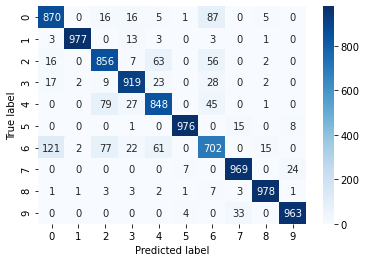

In [ ]:
# Plot non-normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def get_label_text(label):
    if label == 0:
        return 'T-shirt/top'
    elif label == 1:
        return 'Trouser'
    elif label == 2:
        return 'Pullover'
    elif label == 3:
        return 'Dress'
    elif label == 4:
        return 'Coat'
    elif label == 5:
        return 'Sandal'
    elif label == 6:
        return 'Shirt'
    elif label == 7:
        return 'Sneaker'
    elif label == 8:
        return 'Bag'
    elif label == 9:
        return 'Ankle boot'

In [ ]:
result = pd.DataFrame({'y_pred': y_pred,'y_test': y_test}, index=None)
result['result'] = y_pred == y_test
failed_result = result[result['result'] == False]
y_pred_text = failed_result['y_pred'].apply(get_label_text)
y_test_text = failed_result['y_test'].apply(get_label_text)
failed_result = failed_result.assign(y_pred_text=pd.Series(y_pred_text))
failed_result = failed_result.assign(y_test_text=pd.Series(y_test_text))

'Sandal'

In [ ]:
# plot first 9 failed images
sample = failed_result.sample(10)
sample

,y_pred,y_test,result,y_pred_text,y_test_text
8536,2,4,False,Pullover,Coat
3700,0,6,False,T-shirt/top,Shirt
7683,2,4,False,Pullover,Coat
147,3,6,False,Dress,Shirt
1129,0,6,False,T-shirt/top,Shirt
1487,4,6,False,Coat,Shirt
9748,6,0,False,Shirt,T-shirt/top
382,0,2,False,T-shirt/top,Pullover
5334,3,0,False,Dress,T-shirt/top
8958,2,4,False,Pullover,Coat


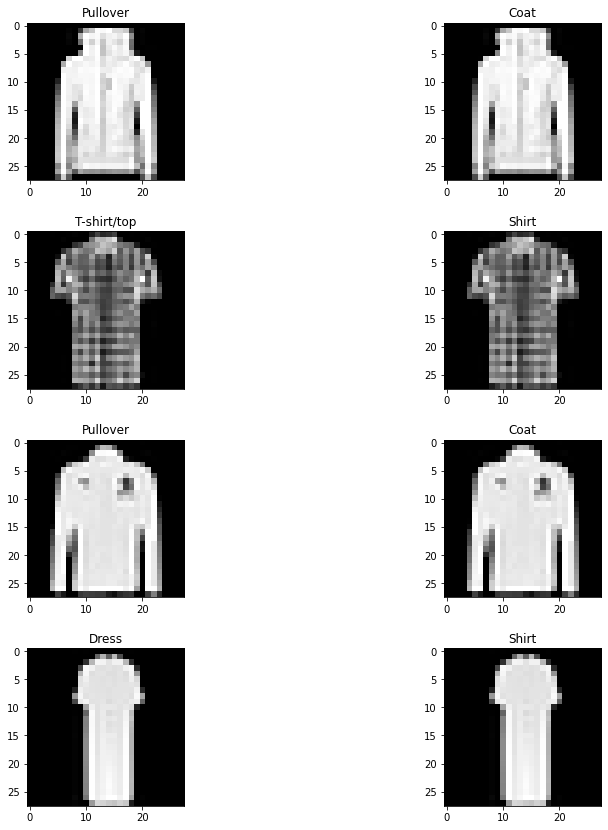

In [ ]:
# define subplot
fig, ax = plt.subplots(4, 2, figsize=(12,12))
fig.tight_layout(pad=3.0)

ax[0][0].imshow(np.array(X_test[sample.index[0]]), cmap=plt.get_cmap('gray'))
ax[0][0].set_title(sample['y_pred_text'].iloc[0])
ax[0][1].imshow(np.array(X_test[sample.index[0]]), cmap=plt.get_cmap('gray'))
ax[0][1].set_title(sample['y_test_text'].iloc[0])
    
ax[1][0].imshow(np.array(X_test[sample.index[1]]), cmap=plt.get_cmap('gray'))
ax[1][0].set_title(sample['y_pred_text'].iloc[1])
ax[1][1].imshow(np.array(X_test[sample.index[1]]), cmap=plt.get_cmap('gray'))
ax[1][1].set_title(sample['y_test_text'].iloc[1])

ax[2][0].imshow(np.array(X_test[sample.index[2]]), cmap=plt.get_cmap('gray'))
ax[2][0].set_title(sample['y_pred_text'].iloc[2])
ax[2][1].imshow(np.array(X_test[sample.index[2]]), cmap=plt.get_cmap('gray'))
ax[2][1].set_title(sample['y_test_text'].iloc[2])

ax[3][0].imshow(np.array(X_test[sample.index[3]]), cmap=plt.get_cmap('gray'))
ax[3][0].set_title(sample['y_pred_text'].iloc[3])
ax[3][1].imshow(np.array(X_test[sample.index[3]]), cmap=plt.get_cmap('gray'))
ax[3][1].set_title(sample['y_test_text'].iloc[3])
# show the figure
plt.show()

# 	Bonus: Boosted Tree Classifier on BigQuery
To improve speed we can implement XGBoost on BigQuery

In [ ]:
CREATE OR REPLACE MODEL `optical-scarab-285012.mnist_fashion.TreeClassifier`
OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
        BOOSTER_TYPE = 'GBTREE',
        NUM_PARALLEL_TREE = 10,
        MAX_ITERATIONS = 200,
        MAX_TREE_DEPTH = 20,
        TREE_METHOD = 'AUTO',
        SUBSAMPLE = 1,
        INPUT_LABEL_COLS = ['label'])
AS SELECT * FROM `optical-scarab-285012.mnist_fashion.mnist_fashion_train`;

[21:00:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:764: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [ ]:
SELECT
  *
FROM
  ML.EVALUATE(MODEL `mnist_fashion.TreeClassifier`,
    (
    SELECT
      *
    FROM
      `optical-scarab-285012.mnist_fashion.mnist_fashion_test`))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783'] ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel91', 'pixel92', 'pixel93', 'pixel94', 'pixel95', 'pixel96', 'pixel97', 'pixel98', 'pixel99', 'pixel100', 'pixel101', 'pixel102', 'pixel103', 'pixel104', 'pixel105', 'pixel106', 'pixel107', 'pixel108', 'pixel109', 'pixel110', 'pixel111', 'pixel112', 'pixel113', 'pixel114', 'pixel115', 'pixel116', 'pixel117', 'pixel118', 'pixel119', 'pixel120', 'pixel121', 'pixel122', 'pixel123', 'pixel124', 'pixel125', 'pixel126', 'pixel127', 'pixel128', 'pixel129', 'pixel130', 'pixel131', 'pixel132', 'pixel133', 'pixel134', 'pixel135', 'pixel136', 'pixel137', 'pixel138', 'pixel139', 'pixel140', 'pixel141', 'pixel142', 'pixel143', 'pixel144', 'pixel145', 'pixel146', 'pixel147', 'pixel148', 'pixel149', 'pixel150', 'pixel151', 'pixel152', 'pixel153', 'pixel154', 'pixel155', 'pixel156', 'pixel157', 'pixel158', 'pixel159', 'pixel160', 'pixel161', 'pixel162', 'pixel163', 'pixel164', 'pixel165', 'pixel166', 'pixel167', 'pixel168', 'pixel169', 'pixel170', 'pixel171', 'pixel172', 'pixel173', 'pixel174', 'pixel175', 'pixel176', 'pixel177', 'pixel178', 'pixel179', 'pixel180', 'pixel181', 'pixel182', 'pixel183', 'pixel184', 'pixel185', 'pixel186', 'pixel187', 'pixel188', 'pixel189', 'pixel190', 'pixel191', 'pixel192', 'pixel193', 'pixel194', 'pixel195', 'pixel196', 'pixel197', 'pixel198', 'pixel199', 'pixel200', 'pixel201', 'pixel202', 'pixel203', 'pixel204', 'pixel205', 'pixel206', 'pixel207', 'pixel208', 'pixel209', 'pixel210', 'pixel211', 'pixel212', 'pixel213', 'pixel214', 'pixel215', 'pixel216', 'pixel217', 'pixel218', 'pixel219', 'pixel220', 'pixel221', 'pixel222', 'pixel223', 'pixel224', 'pixel225', 'pixel226', 'pixel227', 'pixel228', 'pixel229', 'pixel230', 'pixel231', 'pixel232', 'pixel233', 'pixel234', 'pixel235', 'pixel236', 'pixel237', 'pixel238', 'pixel239', 'pixel240', 'pixel241', 'pixel242', 'pixel243', 'pixel244', 'pixel245', 'pixel246', 'pixel247', 'pixel248', 'pixel249', 'pixel250', 'pixel251', 'pixel252', 'pixel253', 'pixel254', 'pixel255', 'pixel256', 'pixel257', 'pixel258', 'pixel259', 'pixel260', 'pixel261', 'pixel262', 'pixel263', 'pixel264', 'pixel265', 'pixel266', 'pixel267', 'pixel268', 'pixel269', 'pixel270', 'pixel271', 'pixel272', 'pixel273', 'pixel274', 'pixel275', 'pixel276', 'pixel277', 'pixel278', 'pixel279', 'pixel280', 'pixel281', 'pixel282', 'pixel283', 'pixel284', 'pixel285', 'pixel286', 'pixel287', 'pixel288', 'pixel289', 'pixel290', 'pixel291', 'pixel292', 'pixel293', 'pixel294', 'pixel295', 'pixel296', 'pixel297', 'pixel298', 'pixel299', 'pixel300', 'pixel301', 'pixel302', 'pixel303', 'pixel304', 'pixel305', 'pixel306', 'pixel307', 'pixel308', 'pixel309', 'pixel310', 'pixel311', 'pixel312', 'pixel313', 'pixel314', 'pixel315', 'pixel316', 'pixel317', 'pixel318', 'pixel319', 'pixel320', 'pixel321', 'pixel322', 'pixel323', 'pixel324', 'pixel325', 'pixel326', 'pixel327', 'pixel328', 'pixel329', 'pixel330', 'pixel331', 'pixel332', 'pixel333', 'pixel334', 'pixel335', 'pixel336', 'pixel337', 'pixel338', 'pixel339', 'pixel340', 'pixel341', 'pixel342', 'pixel343', 'pixel344', 'pixel345', 'pixel346', 'pixel347', 'pixel348', 'pixel349', 'pixel350', 'pixel351', 'pixel352', 'pixel353', 'pixel354', 'pixel355', 'pixel356', 'pixel357', 'pixel358', 'pixel359', 'pixel360', 'pixel361', 'pixel362', 'pixel363', 'pixel364', 'pixel365', 'pixel366', 'pixel367', 'pixel368', 'pixel369', 'pixel370', 'pixel371', 'pixel372', 'pixel373', 'pixel374', 'pixel375', 'pixel376', 'pixel377', 'pixel378', 'pixel379', 'pixel380', 'pixel381', 'pixel382', 'pixel383', 'pixel384', 'pixel385', 'pixel386', 'pixel387', 'pixel388', 'pixel389', 'pixel390', 'pixel391', 'pixel392', 'pixel393', 'pixel394', 'pixel395', 'pixel396', 'pixel397', 'pixel398', 'pixel399', 'pixel400', 'pixel401', 'pixel402', 'pixel403', 'pixel404', 'pixel405', 'pixel406', 'pixel407', 'pixel408', 'pixel409', 'pixel410', 'pixel411', 'pixel412', 'pixel413', 'pixel414', 'pixel415', 'pixel416', 'pixel417', 'pixel418', 'pixel419', 'pixel420', 'pixel421', 'pixel422', 'pixel423', 'pixel424', 'pixel425', 'pixel426', 'pixel427', 'pixel428', 'pixel429', 'pixel430', 'pixel431', 'pixel432', 'pixel433', 'pixel434', 'pixel435', 'pixel436', 'pixel437', 'pixel438', 'pixel439', 'pixel440', 'pixel441', 'pixel442', 'pixel443', 'pixel444', 'pixel445', 'pixel446', 'pixel447', 'pixel448', 'pixel449', 'pixel450', 'pixel451', 'pixel452', 'pixel453', 'pixel454', 'pixel455', 'pixel456', 'pixel457', 'pixel458', 'pixel459', 'pixel460', 'pixel461', 'pixel462', 'pixel463', 'pixel464', 'pixel465', 'pixel466', 'pixel467', 'pixel468', 'pixel469', 'pixel470', 'pixel471', 'pixel472', 'pixel473', 'pixel474', 'pixel475', 'pixel476', 'pixel477', 'pixel478', 'pixel479', 'pixel480', 'pixel481', 'pixel482', 'pixel483', 'pixel484', 'pixel485', 'pixel486', 'pixel487', 'pixel488', 'pixel489', 'pixel490', 'pixel491', 'pixel492', 'pixel493', 'pixel494', 'pixel495', 'pixel496', 'pixel497', 'pixel498', 'pixel499', 'pixel500', 'pixel501', 'pixel502', 'pixel503', 'pixel504', 'pixel505', 'pixel506', 'pixel507', 'pixel508', 'pixel509', 'pixel510', 'pixel511', 'pixel512', 'pixel513', 'pixel514', 'pixel515', 'pixel516', 'pixel517', 'pixel518', 'pixel519', 'pixel520', 'pixel521', 'pixel522', 'pixel523', 'pixel524', 'pixel525', 'pixel526', 'pixel527', 'pixel528', 'pixel529', 'pixel530', 'pixel531', 'pixel532', 'pixel533', 'pixel534', 'pixel535', 'pixel536', 'pixel537', 'pixel538', 'pixel539', 'pixel540', 'pixel541', 'pixel542', 'pixel543', 'pixel544', 'pixel545', 'pixel546', 'pixel547', 'pixel548', 'pixel549', 'pixel550', 'pixel551', 'pixel552', 'pixel553', 'pixel554', 'pixel555', 'pixel556', 'pixel557', 'pixel558', 'pixel559', 'pixel560', 'pixel561', 'pixel562', 'pixel563', 'pixel564', 'pixel565', 'pixel566', 'pixel567', 'pixel568', 'pixel569', 'pixel570', 'pixel571', 'pixel572', 'pixel573', 'pixel574', 'pixel575', 'pixel576', 'pixel577', 'pixel578', 'pixel579', 'pixel580', 'pixel581', 'pixel582', 'pixel583', 'pixel584', 'pixel585', 'pixel586', 'pixel587', 'pixel588', 'pixel589', 'pixel590', 'pixel591', 'pixel592', 'pixel593', 'pixel594', 'pixel595', 'pixel596', 'pixel597', 'pixel598', 'pixel599', 'pixel600', 'pixel601', 'pixel602', 'pixel603', 'pixel604', 'pixel605', 'pixel606', 'pixel607', 'pixel608', 'pixel609', 'pixel610', 'pixel611', 'pixel612', 'pixel613', 'pixel614', 'pixel615', 'pixel616', 'pixel617', 'pixel618', 'pixel619', 'pixel620', 'pixel621', 'pixel622', 'pixel623', 'pixel624', 'pixel625', 'pixel626', 'pixel627', 'pixel628', 'pixel629', 'pixel630', 'pixel631', 'pixel632', 'pixel633', 'pixel634', 'pixel635', 'pixel636', 'pixel637', 'pixel638', 'pixel639', 'pixel640', 'pixel641', 'pixel642', 'pixel643', 'pixel644', 'pixel645', 'pixel646', 'pixel647', 'pixel648', 'pixel649', 'pixel650', 'pixel651', 'pixel652', 'pixel653', 'pixel654', 'pixel655', 'pixel656', 'pixel657', 'pixel658', 'pixel659', 'pixel660', 'pixel661', 'pixel662', 'pixel663', 'pixel664', 'pixel665', 'pixel666', 'pixel667', 'pixel668', 'pixel669', 'pixel670', 'pixel671', 'pixel672', 'pixel673', 'pixel674', 'pixel675', 'pixel676', 'pixel677', 'pixel678', 'pixel679', 'pixel680', 'pixel681', 'pixel682', 'pixel683', 'pixel684', 'pixel685', 'pixel686', 'pixel687', 'pixel688', 'pixel689', 'pixel690', 'pixel691', 'pixel692', 'pixel693', 'pixel694', 'pixel695', 'pixel696', 'pixel697', 'pixel698', 'pixel699', 'pixel700', 'pixel701', 'pixel702', 'pixel703', 'pixel704', 'pixel705', 'pixel706', 'pixel707', 'pixel708', 'pixel709', 'pixel710', 'pixel711', 'pixel712', 'pixel713', 'pixel714', 'pixel715', 'pixel716', 'pixel717', 'pixel718', 'pixel719', 'pixel720', 'pixel721', 'pixel722', 'pixel723', 'pixel724', 'pixel725', 'pixel726', 'pixel727', 'pixel728', 'pixel729', 'pixel730', 'pixel731', 'pixel732', 'pixel733', 'pixel734', 'pixel735', 'pixel736', 'pixel737', 'pixel738', 'pixel739', 'pixel740', 'pixel741', 'pixel742', 'pixel743', 'pixel744', 'pixel745', 'pixel746', 'pixel747', 'pixel748', 'pixel749', 'pixel750', 'pixel751', 'pixel752', 'pixel753', 'pixel754', 'pixel755', 'pixel756', 'pixel757', 'pixel758', 'pixel759', 'pixel760', 'pixel761', 'pixel762', 'pixel763', 'pixel764', 'pixel765', 'pixel766', 'pixel767', 'pixel768', 'pixel769', 'pixel770', 'pixel771', 'pixel772', 'pixel773', 'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780', 'pixel781', 'pixel782', 'pixel783', 'pixel784']
expected f52, f424, f671, f337, f446, f105, f53, f368, f14, f338, f743, f323, f41, f120, f409, f238, f221, f374, f525, f35, f196, f129, f320, f477, f695, f396, f615, f483, f670, f596, f649, f532, f183, f349, f328, f206, f709, f517, f725, f612, f690, f305, f692, f703, f389, f139, f250, f698, f325, f604, f766, f516, f738, f310, f29, f43, f614, f434, f746, f333, f211, f384, f274, f524, f656, f655, f543, f675, f747, f126, f430, f266, f364, f390, f69, f432, f669, f197, f606, f79, f122, f769, f357, f480, f678, f429, f198, f627, f717, f157, f324, f472, f254, f507, f19, f162, f506, f138, f370, f187, f457, f530, f641, f168, f170, f550, f20, f207, f750, f559, f237, f493, f600, f113, f610, f499, f67, f526, f189, f300, f676, f62, f497, f560, f184, f482, f660, f72, f194, f771, f713, f582, f34, f179, f125, f218, f459, f88, f659, f185, f291, f495, f382, f287, f30, f415, f127, f512, f91, f230, f397, f431, f379, f591, f408, f405, f142, f327, f468, f27, f85, f317, f308, f145, f663, f352, f112, f539, f204, f566, f372, f674, f727, f681, f779, f346, f448, f586, f723, f102, f597, f613, f386, f76, f191, f367, f402, f340, f453, f98, f454, f696, f94, f32, f699, f100, f458, f593, f672, f599, f78, f252, f521, f377, f759, f283, f276, f16, f540, f617, f648, f544, f348, f355, f427, f33, f718, f130, f485, f242, f436, f594, f319, f537, f84, f332, f0, f400, f644, f156, f611, f281, f464, f387, f121, f476, f662, f296, f514, f115, f638, f761, f536, f239, f107, f303, f568, f40, f60, f116, f104, f428, f425, f210, f394, f538, f768, f666, f484, f714, f449, f47, f190, f511, f461, f710, f724, f109, f553, f510, f268, f395, f492, f555, f633, f31, f762, f401, f665, f302, f347, f311, f361, f181, f233, f279, f421, f702, f772, f451, f161, f554, f178, f18, f679, f25, f358, f576, f290, f209, f220, f478, f117, f642, f589, f215, f774, f645, f572, f155, f42, f412, f103, f625, f391, f92, f304, f551, f632, f54, f165, f321, f393, f12, f97, f683, f583, f10, f380, f114, f609, f77, f749, f17, f527, f55, f378, f757, f629, f264, f143, f205, f740, f420, f491, f354, f601, f223, f222, f36, f444, f166, f471, f584, f163, f505, f224, f175, f11, f422, f509, f619, f531, f2, f487, f607, f417, f569, f435, f285, f556, f173, f438, f135, f549, f152, f585, f1, f82, f257, f697, f154, f217, f399, f141, f518, f668, f722, f253, f508, f273, f637, f68, f685, f65, f733, f331, f657, f456, f8, f270, f701, f293, f326, f148, f500, f623, f136, f231, f297, f284, f373, f534, f622, f144, f707, f573, f578, f775, f149, f244, f339, f557, f630, f721, f246, f658, f650, f404, f44, f631, f314, f440, f742, f356, f108, f689, f781, f58, f132, f376, f193, f450, f406, f75, f488, f56, f546, f647, f101, f150, f110, f147, f64, f381, f249, f592, f410, f541, f345, f260, f418, f730, f437, f780, f202, f225, f232, f558, f731, f751, f620, f235, f174, f653, f176, f673, f579, f407, f688, f86, f292, f486, f734, f363, f563, f447, f587, f691, f375, f258, f330, f350, f755, f533, f764, f87, f767, f686, f23, f106, f618, f561, f140, f315, f111, f280, f295, f552, f366, f251, f63, f547, f172, f123, f167, f640, f22, f545, f234, f385, f329, f548, f729, f192, f708, f634, f765, f306, f504, f624, f371, f61, f423, f778, f301, f118, f96, f479, f334, f351, f466, f403, f626, f411, f3, f24, f602, f528, f269, f45, f353, f81, f651, f520, f608, f365, f744, f50, f131, f188, f335, f151, f282, f241, f318, f83, f705, f177, f621, f754, f48, f80, f201, f489, f498, f719, f523, f535, f344, f243, f6, f28, f694, f716, f359, f200, f490, f735, f146, f562, f445, f398, f248, f598, f228, f255, f288, f343, f38, f416, f433, f169, f247, f501, f133, f565, f216, f628, f776, f199, f51, f463, f307, f441, f278, f502, f639, f684, f770, f124, f240, f680, f522, f159, f580, f89, f316, f462, f737, f567, f728, f741, f752, f732, f261, f336, f360, f570, f664, f262, f693, f195, f715, f57, f265, f577, f575, f312, f413, f636, f5, f513, f652, f21, f245, f465, f682, f369, f73, f519, f777, f90, f309, f214, f494, f571, f590, f227, f236, f414, f119, f298, f616, f473, f687, f739, f392, f171, f439, f646, f470, f503, f588, f259, f758, f71, f706, f756, f661, f383, f134, f452, f362, f474, f182, f272, f773, f15, f574, f208, f667, f455, f49, f496, f263, f442, f39, f277, f760, f469, f726, f158, f186, f467, f13, f763, f748, f736, f481, f294, f203, f37, f635, f342, f581, f256, f475, f93, f782, f745, f700, f160, f128, f267, f99, f460, f275, f70, f419, f153, f137, f271, f711, f564, f643, f7, f720, f4, f289, f59, f605, f95, f783, f180, f219, f74, f226, f164, f66, f213, f46, f286, f313, f426, f595, f26, f542, f677, f712, f212, f529, f443, f388, f704, f229, f341, f753, f603, f654, f515, f322, f299, f9 in input data
training data did not have the following fields: pixel643, pixel63, pixel685, pixel148, pixel359, pixel214, pixel4, pixel75, pixel233, pixel47, pixel440, pixel150, pixel40, pixel345, pixel515, pixel172, pixel541, pixel734, pixel471, pixel313, pixel61, pixel122, pixel325, pixel760, pixel96, pixel761, pixel505, pixel620, pixel556, pixel637, pixel352, pixel657, pixel741, pixel280, pixel465, pixel751, pixel94, pixel447, pixel384, pixel38, pixel54, pixel729, pixel297, pixel776, pixel9, pixel411, pixel133, pixel494, pixel656, pixel106, pixel95, pixel703, pixel307, pixel522, pixel424, pixel765, pixel451, pixel145, pixel291, pixel513, pixel161, pixel115, pixel162, pixel205, pixel380, pixel335, pixel679, pixel282, pixel757, pixel334, pixel570, pixel594, pixel238, pixel3, pixel159, pixel305, pixel314, pixel537, pixel640, pixel658, pixel695, pixel37, pixel339, pixel369, pixel25, pixel418, pixel771, pixel285, pixel286, pixel721, pixel508, pixel482, pixel104, pixel247, pixel480, pixel723, pixel553, pixel358, pixel624, pixel452, pixel633, pixel123, pixel758, pixel173, pixel533, pixel250, pixel235, pixel715, pixel659, pixel391, pixel149, pixel611, pixel2, pixel655, pixel616, pixel647, pixel362, pixel450, pixel136, pixel387, pixel485, pixel563, pixel701, pixel421, pixel293, pixel271, pixel460, pixel436, pixel355, pixel17, pixel67, pixel458, pixel548, pixel468, pixel649, pixel116, pixel199, pixel316, pixel542, pixel767, pixel195, pixel488, pixel631, pixel664, pixel410, pixel561, pixel119, pixel400, pixel634, pixel744, pixel687, pixel603, pixel41, pixel135, pixel182, pixel524, pixel55, pixel216, pixel742, pixel10, pixel53, pixel601, pixel215, pixel733, pixel258, pixel768, pixel147, pixel277, pixel448, pixel311, pixel590, pixel272, pixel228, pixel618, pixel588, pixel187, pixel198, pixel12, pixel486, pixel46, pixel292, pixel219, pixel224, pixel678, pixel532, pixel539, pixel158, pixel752, pixel779, pixel770, pixel551, pixel617, pixel762, pixel521, pixel29, pixel73, pixel178, pixel584, pixel683, pixel737, pixel266, pixel608, pixel156, pixel256, pixel244, pixel90, pixel738, pixel196, pixel168, pixel531, pixel412, pixel296, pixel654, pixel308, pixel257, pixel288, pixel726, pixel748, pixel444, pixel388, pixel366, pixel479, pixel18, pixel434, pixel535, pixel140, pixel93, pixel693, pixel613, pixel114, pixel579, pixel206, pixel638, pixel35, pixel732, pixel82, pixel36, pixel183, pixel79, pixel321, pixel185, pixel516, pixel753, pixel700, pixel84, pixel740, pixel255, pixel117, pixel295, pixel427, pixel432, pixel102, pixel666, pixel64, pixel627, pixel395, pixel453, pixel606, pixel143, pixel341, pixel651, pixel511, pixel189, pixel602, pixel58, pixel754, pixel646, pixel467, pixel526, pixel315, pixel566, pixel8, pixel706, pixel68, pixel675, pixel72, pixel201, pixel573, pixel217, pixel85, pixel774, pixel7, pixel442, pixel568, pixel503, pixel310, pixel443, pixel348, pixel769, pixel229, pixel572, pixel402, pixel662, pixel27, pixel344, pixel283, pixel682, pixel713, pixel137, pixel523, pixel500, pixel545, pixel191, pixel671, pixel416, pixel322, pixel188, pixel181, pixel363, pixel202, pixel204, pixel669, pixel192, pixel690, pixel97, pixel88, pixel239, pixel642, pixel91, pixel670, pixel128, pixel16, pixel373, pixel491, pixel375, pixel419, pixel575, pixel300, pixel403, pixel677, pixel547, pixel653, pixel372, pixel267, pixel763, pixel689, pixel129, pixel263, pixel749, pixel527, pixel720, pixel353, pixel717, pixel243, pixel660, pixel368, pixel605, pixel177, pixel66, pixel241, pixel262, pixel404, pixel546, pixel641, pixel74, pixel394, pixel484, pixel56, pixel346, pixel260, pixel142, pixel383, pixel397, pixel21, pixel275, pixel462, pixel113, pixel730, pixel167, pixel318, pixel326, pixel207, pixel242, pixel512, pixel44, pixel558, pixel783, pixel589, pixel349, pixel507, pixel81, pixel536, pixel585, pixel773, pixel422, pixel439, pixel596, pixel530, pixel635, pixel160, pixel466, pixel144, pixel420, pixel379, pixel386, pixel529, pixel273, pixel501, pixel425, pixel704, pixel766, pixel557, pixel506, pixel707, pixel371, pixel702, pixel86, pixel615, pixel597, pixel157, pixel45, pixel30, pixel98, pixel544, pixel457, pixel667, pixel772, pixel510, pixel600, pixel598, pixel525, pixel519, pixel609, pixel227, pixel264, pixel13, pixel338, pixel287, pixel340, pixel399, pixel650, pixel449, pixel625, pixel194, pixel210, pixel487, pixel376, pixel146, pixel151, pixel736, pixel155, pixel302, pixel716, pixel473, pixel170, pixel59, pixel324, pixel469, pixel604, pixel87, pixel186, pixel632, pixel586, pixel92, pixel756, pixel1, pixel184, pixel636, pixel571, pixel735, pixel784, pixel175, pixel514, pixel360, pixel493, pixel398, pixel77, pixel509, pixel385, pixel279, pixel141, pixel724, pixel281, pixel154, pixel100, pixel236, pixel782, pixel6, pixel367, pixel481, pixel543, pixel709, pixel592, pixel639, pixel755, pixel299, pixel483, pixel14, pixel232, pixel576, pixel673, pixel697, pixel22, pixel51, pixel534, pixel32, pixel237, pixel284, pixel218, pixel139, pixel674, pixel628, pixel251, pixel252, pixel746, pixel289, pixel347, pixel623, pixel246, pixel269, pixel108, pixel166, pixel619, pixel409, pixel475, pixel718, pixel688, pixel780, pixel180, pixel361, pixel28, pixel65, pixel60, pixel101, pixel504, pixel31, pixel320, pixel731, pixel648, pixel599, pixel414, pixel209, pixel39, pixel152, pixel739, pixel253, pixel672, pixel528, pixel249, pixel323, pixel591, pixel711, pixel728, pixel164, pixel405, pixel274, pixel33, pixel433, pixel24, pixel445, pixel490, pixel710, pixel330, pixel574, pixel459, pixel428, pixel569, pixel350, pixel298, pixel406, pixel80, pixel317, pixel587, pixel583, pixel692, pixel390, pixel225, pixel661, pixel370, pixel461, pixel99, pixel401, pixel612, pixel220, pixel684, pixel668, pixel34, pixel89, pixel103, pixel57, pixel621, pixel125, pixel560, pixel111, pixel629, pixel725, pixel270, pixel71, pixel438, pixel365, pixel336, pixel577, pixel268, pixel743, pixel698, pixel69, pixel130, pixel381, pixel179, pixel120, pixel223, pixel265, pixel665, pixel550, pixel712, pixel567, pixel357, pixel234, pixel211, pixel378, pixel645, pixel174, pixel190, pixel329, pixel393, pixel248, pixel580, pixel415, pixel652, pixel455, pixel708, pixel429, pixel777, pixel492, pixel498, pixel112, pixel413, pixel472, pixel259, pixel278, pixel169, pixel538, pixel221, pixel50, pixel517, pixel19, pixel245, pixel499, pixel354, pixel49, pixel610, pixel226, pixel312, pixel118, pixel70, pixel582, pixel496, pixel377, pixel626, pixel261, pixel454, pixel5, pixel680, pixel254, pixel121, pixel200, pixel476, pixel42, pixel327, pixel470, pixel719, pixel663, pixel11, pixel153, pixel105, pixel276, pixel212, pixel343, pixel208, pixel290, pixel165, pixel478, pixel520, pixel435, pixel132, pixel423, pixel745, pixel764, pixel565, pixel705, pixel562, pixel331, pixel333, pixel127, pixel694, pixel374, pixel759, pixel540, pixel337, pixel176, pixel781, pixel134, pixel489, pixel630, pixel342, pixel306, pixel351, pixel407, pixel203, pixel304, pixel676, pixel441, pixel477, pixel549, pixel644, pixel78, pixel294, pixel396, pixel131, pixel446, pixel83, pixel303, pixel778, pixel696, pixel727, pixel437, pixel230, pixel197, pixel332, pixel382, pixel463, pixel581, pixel747, pixel138, pixel691, pixel518, pixel107, pixel126, pixel20, pixel109, pixel392, pixel686, pixel699, pixel607, pixel48, pixel356, pixel430, pixel464, pixel26, pixel431, pixel564, pixel110, pixel319, pixel775, pixel193, pixel52, pixel622, pixel426, pixel171, pixel595, pixel124, pixel578, pixel502, pixel593, pixel750, pixel364, pixel231, pixel681, pixel222, pixel240, pixel456, pixel559, pixel309, pixel43, pixel614, pixel23, pixel163, pixel389, pixel213, pixel15, pixel495, pixel552, pixel62, pixel714, pixel554, pixel328, pixel417, pixel301, pixel474, pixel76, pixel555, pixel408, pixel722, pixel497